In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import PIL.ImageOps 
from skimage import io
from skimage.filters import roberts, sobel, scharr, prewitt

In [3]:
# get a crop of the upper half of the column
img_flood = io.imread('E:/Python Projekt 5_2 Extraktion/Dataset_split/Test/Flooding/Flooding_2424.png', as_gray=True)
img_flood = cv2.resize(img_flood, (1000,1600))
flooded_cropped = img_flood[155:405, 200:800]

img_norm = io.imread('E:/Python Projekt 5_2 Extraktion/Dataset_split/Test/Regular_State/Regular_State_2136.png', as_gray=True)
img_norm = cv2.resize(img_norm, (1000,1600))
norm_cropped = img_norm[155:405, 200:800]

In [4]:
# get a crop of the lower half of the column
img_flood_low = io.imread('E:/Python Projekt 5_2 Extraktion/Dataset_split/Test/Flooding/Flooding_2424.png', as_gray=True)
img_flood_low = cv2.resize(img_flood_low, (1000,1600))
flooded_cropped_low = img_flood_low[1250:1500, 200:800]

img_norm_low = io.imread('E:/Python Projekt 5_2 Extraktion/Dataset_split/Test/Regular_State/Regular_State_2136.png', as_gray=True)
img_norm_low = cv2.resize(img_norm_low, (1000,1600))
norm_cropped_low = img_norm_low[1250:1500, 200:800]

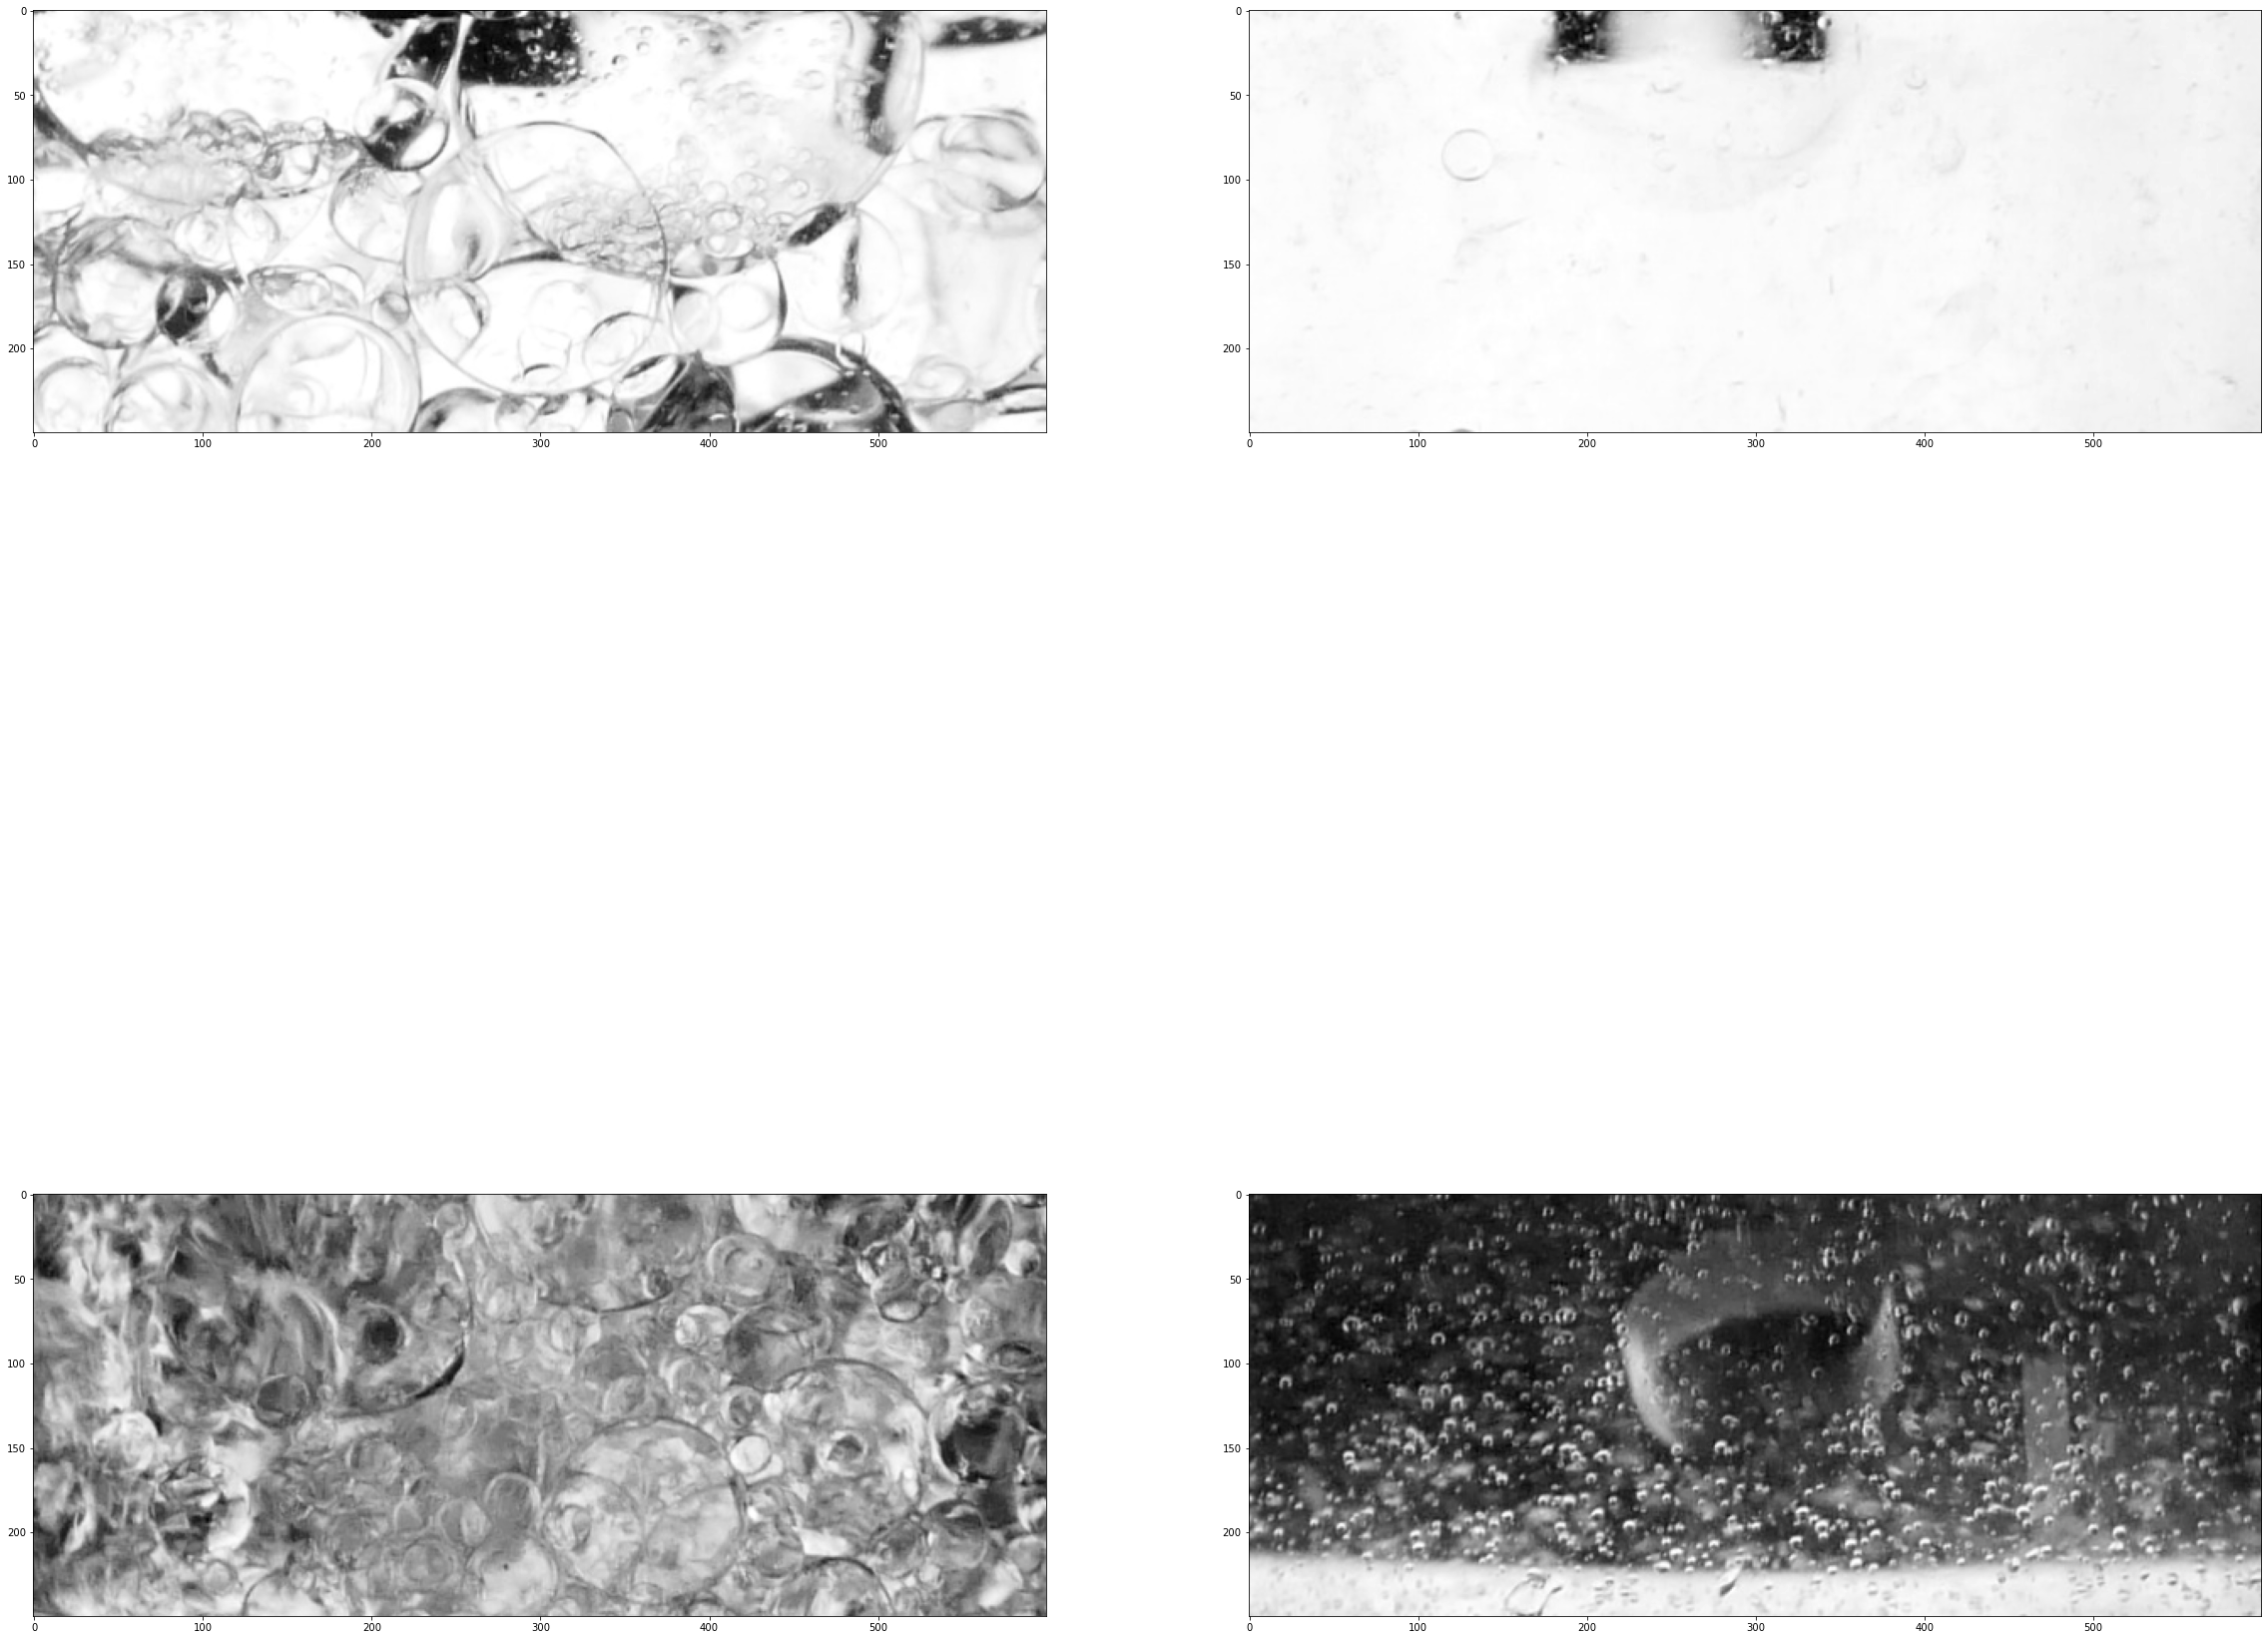

In [5]:
fig, axis = plt.subplots(2,2,figsize = (40,20))

axis[0,0].imshow(flooded_cropped, cmap = plt.cm.gray)
axis[0,1].imshow(norm_cropped, cmap = plt.cm.gray)
axis[1,0].imshow(flooded_cropped_low, cmap = plt.cm.gray)
axis[1,1].imshow(norm_cropped_low, cmap = plt.cm.gray)
plt.savefig('before_processing.png')

In [6]:
#edge detection with scharr filter
edge_scharr_flood = scharr(flooded_cropped)
edge_scharr_norm = scharr(norm_cropped)
edge_scharr_flood_low = scharr(flooded_cropped_low)
edge_scharr_norm_low = scharr(norm_cropped_low)


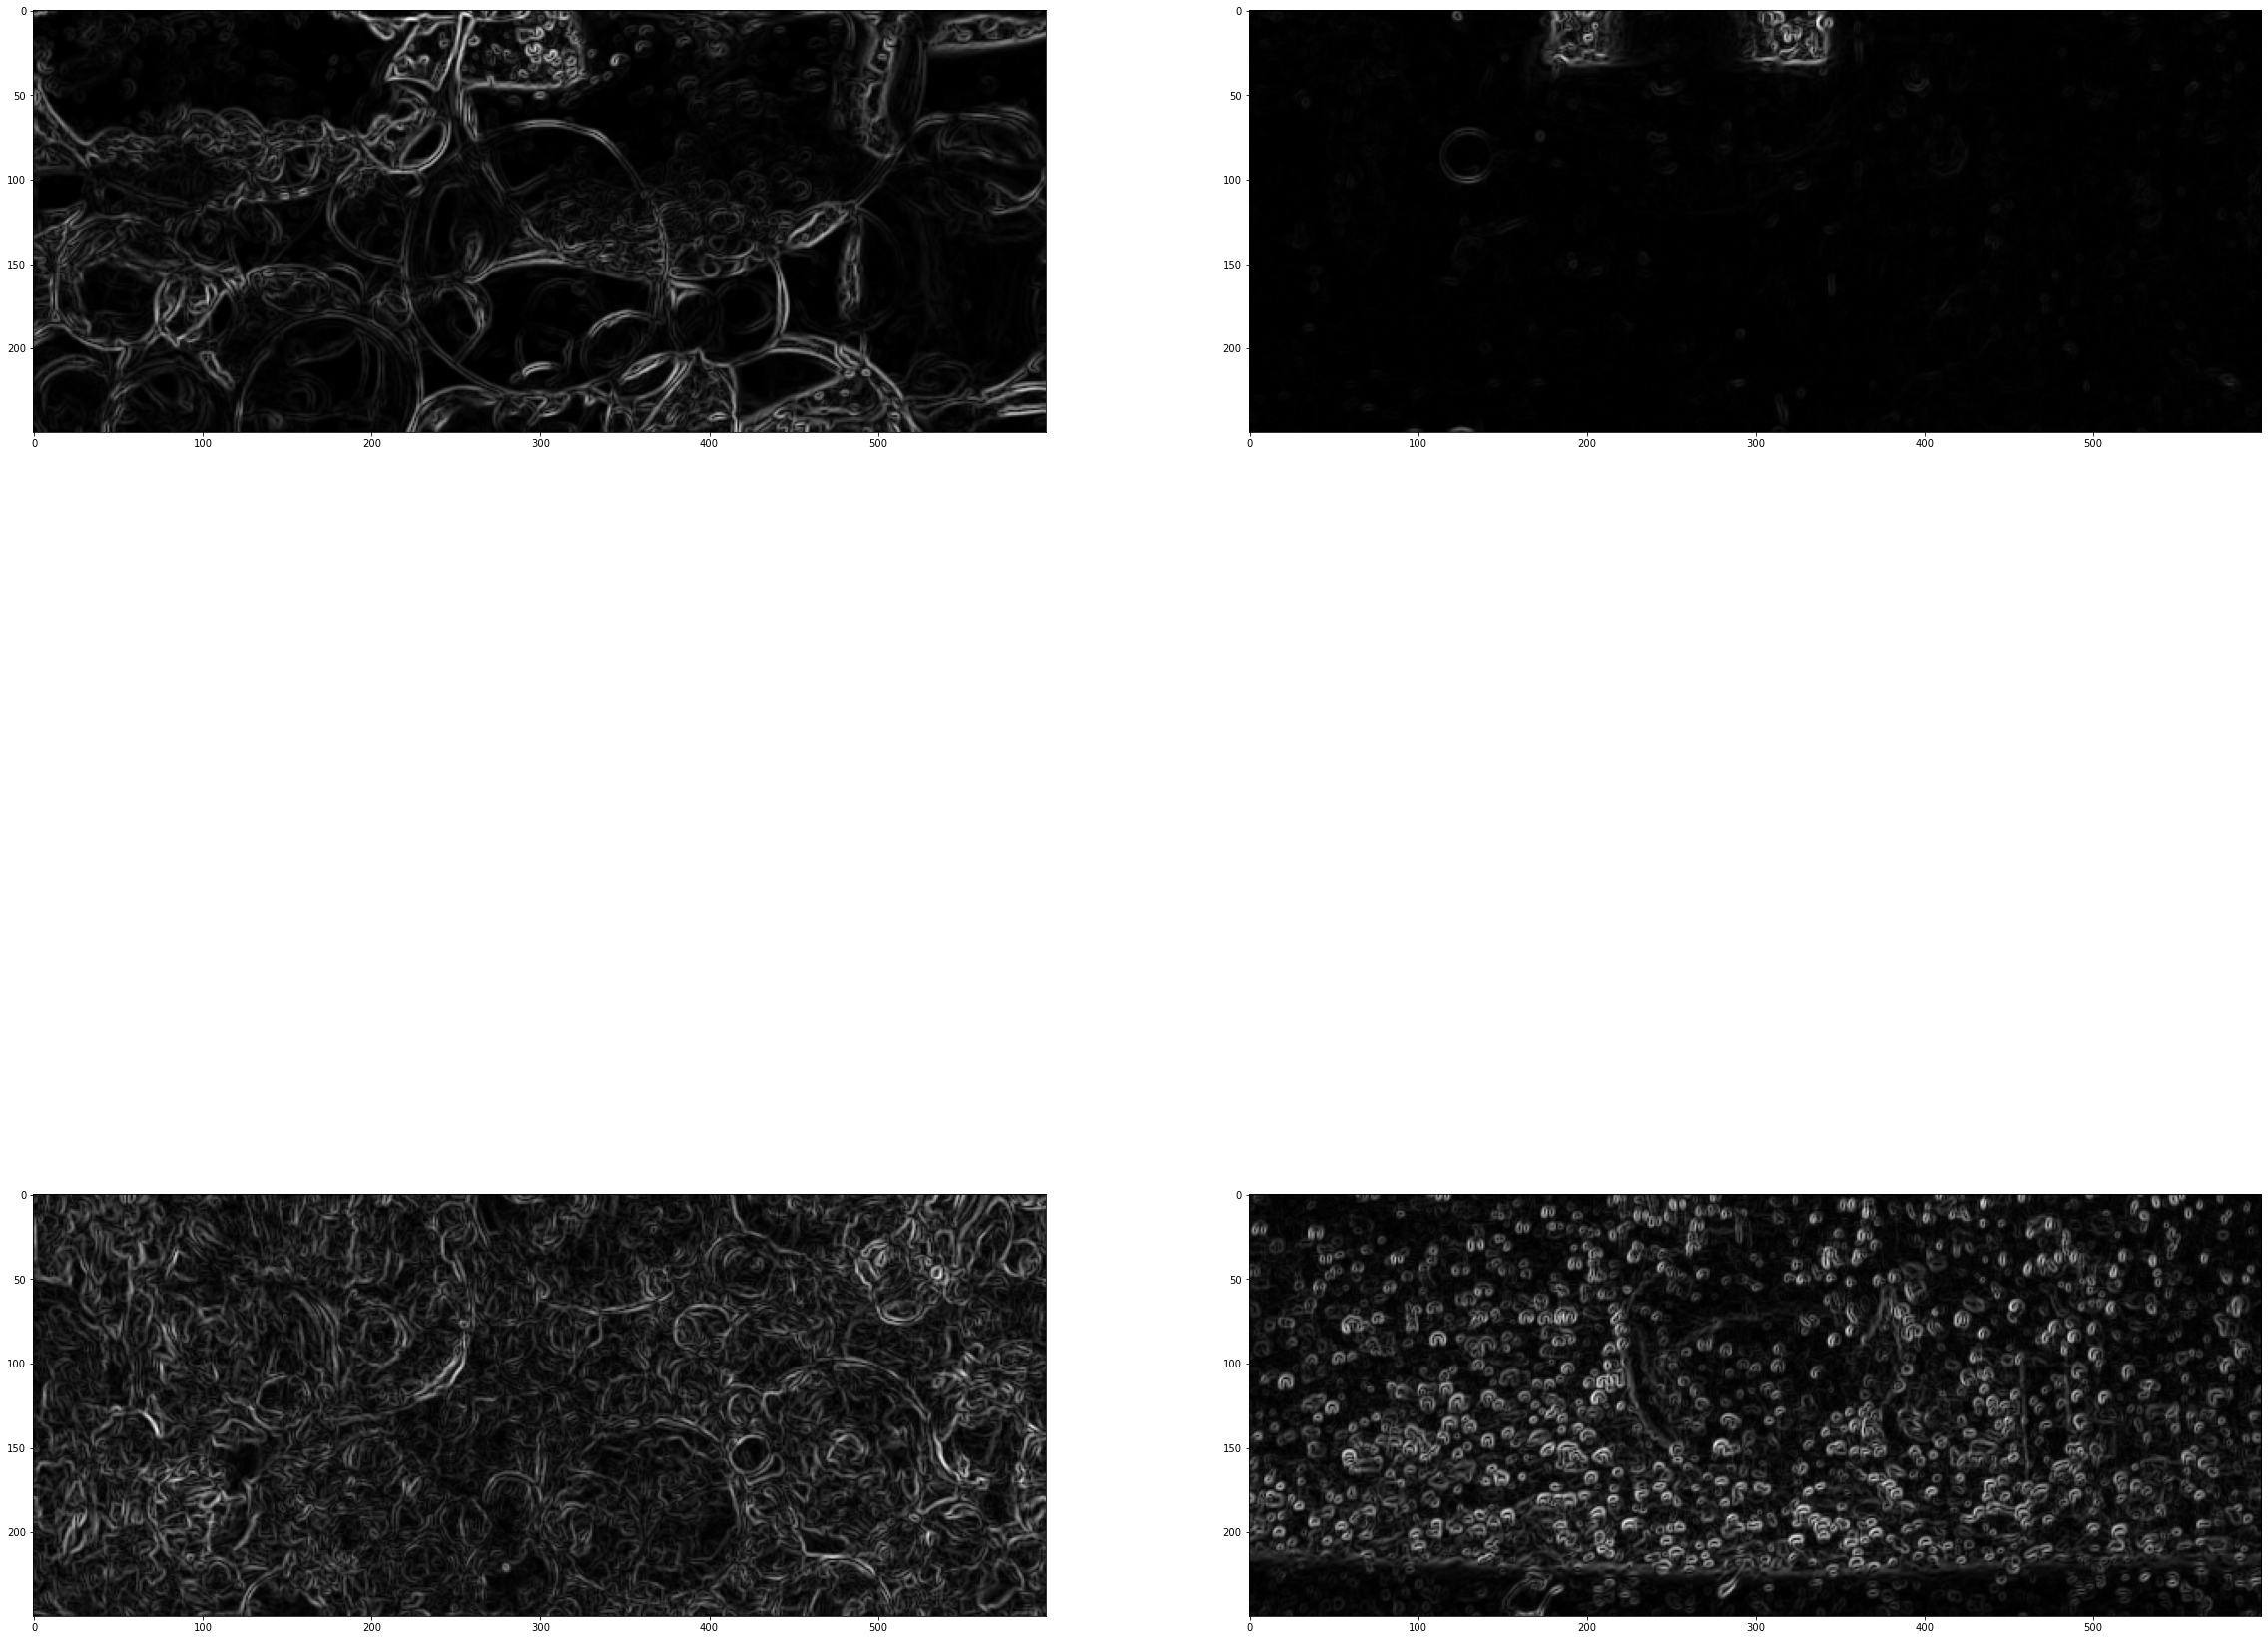

In [7]:
fig, axis = plt.subplots(2,2,figsize = (40,20))

axis[0,0].imshow(edge_scharr_flood, cmap = plt.cm.gray)
axis[0,1].imshow(edge_scharr_norm, cmap = plt.cm.gray)
axis[1,0].imshow(edge_scharr_flood_low, cmap = plt.cm.gray)
axis[1,1].imshow(edge_scharr_norm_low, cmap = plt.cm.gray)
plt.savefig('after scharr.png')

In [9]:
def pixel_enhancer(h,w,img):
    enhanced = img
    for y in range(0,h):
        for x in range(0,w):
            #print(img[y][x])
            if enhanced[y][x] <= 0.05:
                enhanced[y][x] = 0
            if enhanced[y][x] > 0.1:
                enhanced[y][x] = 1
    return enhanced

In [10]:
h_up = edge_scharr_flood.shape[0]
w_up = edge_scharr_flood.shape[1]
h_low = edge_scharr_flood_low.shape[0]
w_low = edge_scharr_flood_low.shape[1]

flood_up = pixel_enhancer(h_up,w_up,edge_scharr_flood)
flood_low = pixel_enhancer(h_low,w_low,edge_scharr_flood_low)
norm_up = pixel_enhancer(h_up,w_up,edge_scharr_norm)
norm_low = pixel_enhancer(h_low,w_low,edge_scharr_norm_low)

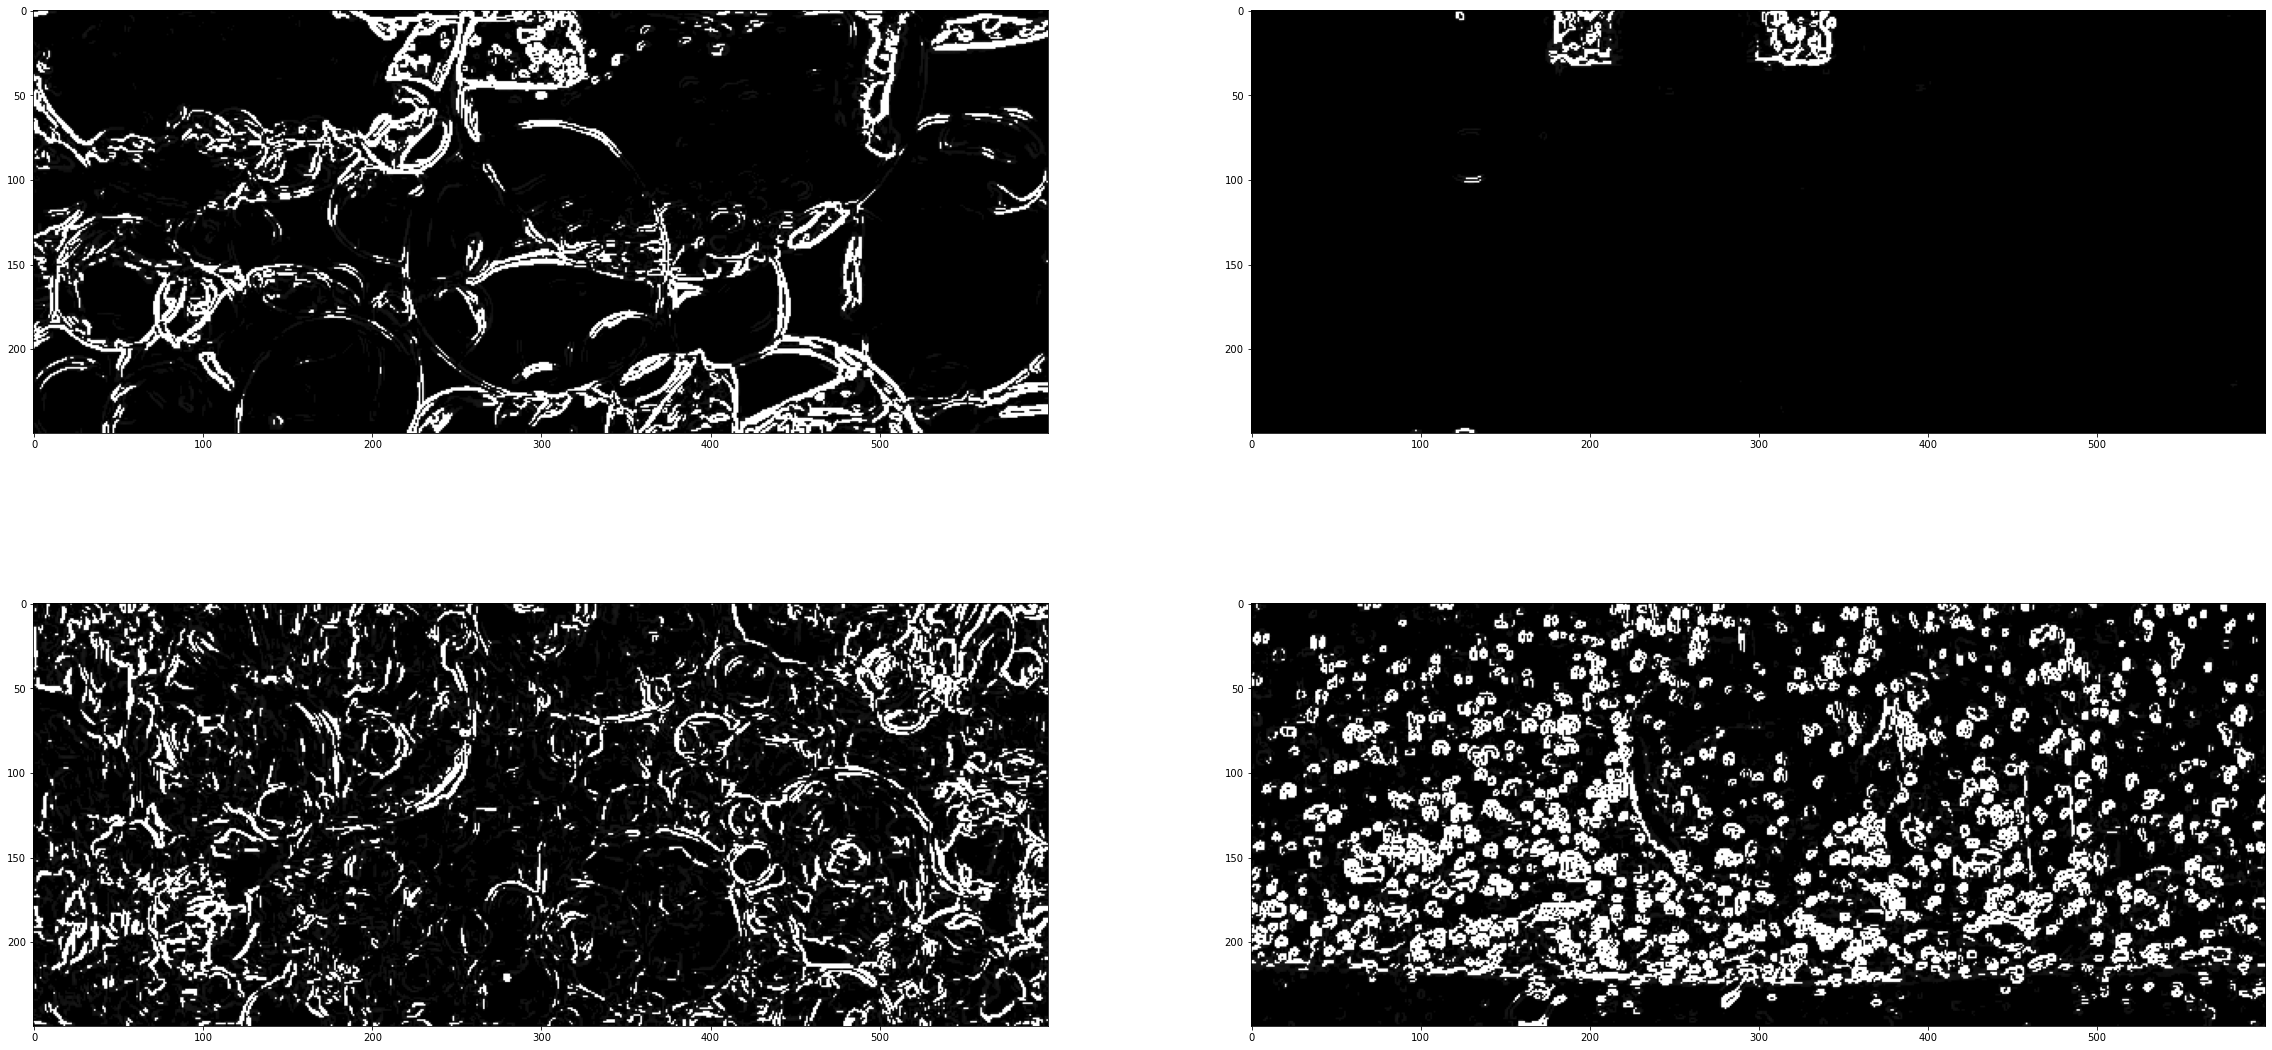

In [12]:
fig, axis = plt.subplots(2,2,figsize = (40,20))

axis[0,0].imshow(flood_up, cmap = plt.cm.gray)
axis[1,0].imshow(flood_low, cmap = plt.cm.gray)
axis[0,1].imshow(norm_up, cmap = plt.cm.gray)
axis[1,1].imshow(norm_low, cmap = plt.cm.gray)
plt.savefig('after_processing.png')

#, dpi=None, facecolor='w', edgecolor='w',
#        orientation='portrait', papertype=None, format=None,
#        transparent=False, bbox_inches=None, pad_inches=0.1,
#        frameon=None, metadata=None

In [13]:
type(flood_up)
flood_up_cv2 = flood_up*255
flood_up_new = flood_up_cv2.astype(np.uint8)
img_HC = flood_up_new
#img_HC = cv2.medianBlur(flood_up_new,5)
circles_flood_up = cv2.HoughCircles(img_HC,cv2.HOUGH_GRADIENT,1,100,
                            param1=30,param2=30,minRadius=30,maxRadius=100)
if circles_flood_up is None:
    print('no bubbles detected')
else:
    circles_flood_up = np.uint16(np.around(circles_flood_up))

In [14]:
print(len(circles_flood_up[0]))

11


In [15]:
for i in circles_flood_up[0,:]:
    cv2.circle(img_HC, (i[0],i[1]),i[2], (255, 112, 232), 2)
    cv2.circle(img_HC, (i[0],i[1]),2, (255, 112, 250), 3)
    
cv2.imshow('Circle Detection',img_HC)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
#idea: devide image in Bottom and Top. Calculate the black pixels. The image with more black pixels is better for 
#circle detection. When a circle number is above a certain value -> flooding 

In [16]:
def dark_pixel_counter(h,w,img):
    dark_pixels = 0
    white_pixels = 0
    for y in range(0,h):
        for x in range(0,w):
            if img[y][x] == 0:
                dark_pixels += 1
    return dark_pixels

In [31]:
def bubble_counter(folder):
    bubbles_count = []
    dark_pixels_up = []
    dark_pixels_low = []
    n = 0
    for filename in os.listdir(folder):
        n+=1
        if n%100 == 0:
            print('{} images were processed'.format(n))
        
        #set n to desired value if you do not want to load all images in the folder
        if n == 1000:
            break
        #devide the image in 2 parts and crop it 
        img_up = io.imread(os.path.join(folder,filename), as_gray=True)
        img_up = cv2.resize(img_up, (1000,1600))
        img_up = img_up[155:405, 200:800]
        
        img_low = io.imread(os.path.join(folder,filename), as_gray=True)
        img_low = cv2.resize(img_low, (1000,1600))
        img_low = img_low[1250:1500, 200:800]
        
        #use edge detection 'scharr' to identify the edges
        img_up_scharr = scharr(img_up)
        img_low_scharr = scharr(img_low)
        
        #get the shape
        h_up = img_up_scharr.shape[0]
        w_up = img_up_scharr.shape[1]
        h_low = img_low_scharr.shape[0]
        w_low = img_low_scharr.shape[1]
        
        #enhance the Pixel, set bright pixel to 1 and darker to 0
        img_up_E = pixel_enhancer(h_up,w_up,img_up_scharr)
        img_low_E = pixel_enhancer(h_low,w_low,img_low_scharr)
        
        #count the black pixels
        upper_dark = dark_pixel_counter(h_up,w_up,img_up_E)
        lower_dark = dark_pixel_counter(h_low,w_low,img_low_E)
        dark_pixels_up.append(upper_dark)
        dark_pixels_low.append(lower_dark)
        
        #use the half with more darker pixels 
        if upper_dark >= lower_dark:
            img_circles = img_up_E
        else:
            img_circles = img_low_E
        
        #use the HoughCircle algorithm to detect circles 
        img_circles_HC = img_circles*255
        img_circles_HC_new = img_circles_HC.astype(np.uint8)
        img_HC = img_circles_HC_new
        #img_HC = cv2.medianBlur(flood_up_new,5)
        bubbles = cv2.HoughCircles(img_HC,cv2.HOUGH_GRADIENT,1,100,
                            param1=30,param2=30,minRadius=30,maxRadius=100)
        
        
        if bubbles is None:
            #when there are no detected circles 
            bubbles_count.append(0)
        else:
            bubbles = np.uint16(np.around(bubbles))
            bubbles_count.append(int(len(bubbles[0])))

    return bubbles_count, dark_pixels_up, dark_pixels_low


In [32]:
#change of directory necessary
state_flooded, dark_pixels_up, dark_pixels_low = bubble_counter('E:/Python Projekt 5_2 Extraktion/Dataset_split/Train/Flooding')

100 images were processed
200 images were processed
300 images were processed
400 images were processed
500 images were processed
600 images were processed
700 images were processed
800 images were processed
900 images were processed
1000 images were processed


In [33]:
#E:\Python Projekt 5_2 Extraktion\Dataset_split\difficult_pictures\Regular_state
state_normal, dark_pixels_up, dark_pixels_low = bubble_counter('E:/Python Projekt 5_2 Extraktion/Dataset_split/Train/Regular_state')


100 images were processed
200 images were processed
300 images were processed
400 images were processed
500 images were processed
600 images were processed
700 images were processed
800 images were processed
900 images were processed
1000 images were processed


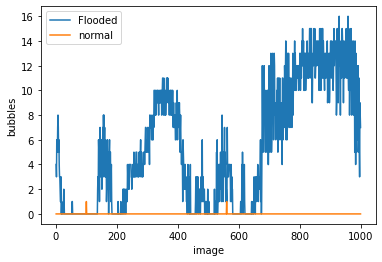

In [34]:
fig = plt.plot(range(1,len(state_flooded)+1),state_flooded, label = 'Flooded')
plt.plot(range(1,len(state_normal)+1),state_normal, label = 'normal')
plt.xlabel('image')
plt.ylabel('bubbles')
plt.legend()
plt.savefig('bubbles_gegen_image')

In [35]:
tp = 0
fn = 0
zaehler = 0
image = []
for state in state_flooded:
    zaehler += 1
    if state >= 1:
        tp += 1
    else:
        fn += 1
        image.append(zaehler)
print(tp,fn)


738 261


In [36]:
tn = 0
fp = 0
zaehler = 0
image_fp = []
for state in state_normal:
    zaehler += 1
    if state < 1:
        tn += 1
    else:
        fp += 1
        image_fp.append(zaehler)
print(tn,fp)


997 2


In [37]:
print(f'There are {tp} true positive, {fp} false positive, {fn} false negativ and {tn} true negativ')
print('The calculations for the recall,the precision and accuracy are:')
print('recall={}'.format(tp/(tp+fn)))
print('precision={}'.format(tp/(tp+fp)))
print('accuracy={}'.format((tp+tn)/(tp+tn+fp+fn)))

There are 738 true positive, 2 false positive, 261 false negativ and 997 true negativ
The calculations for the recall,the precision and accuracy are:
recall=0.7387387387387387
precision=0.9972972972972973
accuracy=0.8683683683683684


In [27]:
state_flooded_test, dark_pixels_up, dark_pixels_low = bubble_counter('E:/Python Projekt 5_2 Extraktion/Dataset_split/Test/Flooding')

100 images were processed


In [28]:
state_normal_test, dark_pixels_up_norm, dark_pixels_low_norm  = bubble_counter('E:/Python Projekt 5_2 Extraktion/Dataset_split/Test/Regular_state')

100 images were processed


In [29]:
tp = 0
fn = 0
zaehler = 0
image = []
for state in state_flooded_test:
    zaehler += 1
    if state >= 1:
        tp += 1
    else:
        fn += 1
        image.append(zaehler)
print(tp,fn)

tn = 0
fp = 0
zaehler = 0
image_fp = []
for state in state_normal_test:
    zaehler += 1
    if state < 1:
        tn += 1
    else:
        fp += 1
        image_fp.append(zaehler)
print(tn,fp)


99 0
99 0


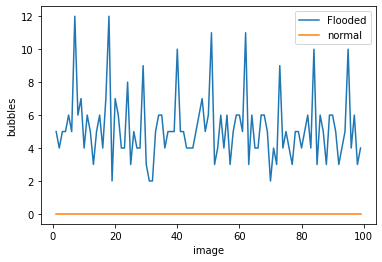

In [30]:
fig = plt.plot(range(1,len(state_flooded_test)+1),state_flooded_test, label = 'Flooded')
plt.plot(range(1,len(state_normal_test)+1),state_normal_test, label = 'normal')

plt.xlabel('image')
plt.ylabel('bubbles')
plt.legend()
plt.savefig('bubbles_gegen_image')

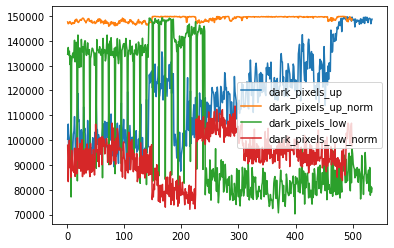

In [615]:
plt.plot(range(1,len(dark_pixels_up)+1),dark_pixels_up, label = 'dark_pixels_up')
plt.plot(range(1,len(dark_pixels_up_norm)+1),dark_pixels_up_norm, label = 'dark_pixels_up_norm')
plt.plot(range(1,len(dark_pixels_low)+1),dark_pixels_low, label = 'dark_pixels_low')
plt.plot(range(1,len(dark_pixels_low_norm)+1),dark_pixels_low_norm, label = 'dark_pixels_low_norm')
plt.legend()

In [601]:
print(f'There are {tp} true positive, {fp} false positive, {fn} false negativ and {tn} true negativ')
print('The calculations for the recall,the precision and accuracy are:')
print('recall={}'.format(tp/(tp+fn)))
print('precision={}'.format(tp/(tp+fp)))
print('accuracy={}'.format((tp+tn)/(tp+tn+fp+fn)))

There are 410 true positive, 0 false positive, 124 false negativ and 499 true negativ
The calculations for the recall,the precision and accuracy are:
recall=0.7677902621722846
precision=1.0
accuracy=0.8799612778315585
